# BilbyAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby runs, including corner plots and evidences

### Imports

In [58]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi
import lal
import lalsimulation as lalsim

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Functions for injection values, Bayes factors, evidences, etc

In [59]:
LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
             'a_1' : r"$a_1$", 'a_2' : r"$a_2$", 'luminosity_distance' : r"$d_L$ [mpc]", \
            'dec' : 'dec', 'ra' : 'ra', 'theta_jn' : r"$\theta_{jn}$", 'tilt_1' : r"$\theta_1$", \
            'tilt_2' : r"$\theta_2$", 'psi' : r"$\psi$", 'phase' : r'$\Delta \phi$', 'chi_eff' : r'$\chi_\mathrm{eff}$', \
            'm_1' : r"$m_1$", 'm_2' : r"$m_2$"}
    
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    TruthDict['m_1'] = params['m_1']
    TruthDict['m_2'] = params['m_2']
    TruthDict['chi_eff'] = params['chi_eff']
    f.close()
    return TruthDict

## Dictionary mapping the various runs with priors in question to labels
ps_dict = {"Test_FullSearchNoTiltNoSkyLoc_35_0p99" : r"All parameter except tilt and sky loc search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.99", 
          "Test_FullSearchNoTilt_35_0p99" : r"Aligned-spin search, $f_\mathrm{min}$ = 35 Hz, $a_\mathrm{max}$ = 0.99", # SNR_net = 95
          "Test_FullSearch_35_0p99" : r"Unanligned-spin search, $f_\mathrm{min}$ = 35 Hz, $a_\mathrm{max}$ = 0.99", # SNR = 95
          "Test_FullSearch_35_0p75" : r"Unanligned-spin search, $f_\mathrm{min}$ = 35 Hz, $a_\mathrm{max}$ = 0.75", # SNR = 95
           "Test_FullSearch_25_0p75" : r"Unanligned-spin search, $f_\mathrm{min}$ = 25 Hz, $a_\mathrm{max}$ = 0.75", # SNR = 95
           "Test_Sur_35_0p99"  : r"Surrogate injection, All parameter search, $f_\mathrm{min}$ = 35 Hz, $a_\mathrm{max}$ = 0.99, SNR = 75",
           "Test_FullSearchNoTilt_25_0p75" : r"Aligned-spin search, $f_\mathrm{min}$ = 25 Hz, $a_\mathrm{max}$ = 0.75",
           "Test_FullSearchNoTilt_35_0p75" : r"Aligned-spin search, $f_\mathrm{min}$ = 35 Hz, $a_\mathrm{max}$ = 0.75",
           "dCS_0p0_25" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 25, $\ell = 0$",
           "dCS_0p0_75" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 75, $\ell = 0$",
           "dCS_0p0_125" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 125, $\ell = 0$",
           "dCS_0p3_25" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 25, $\ell = 0.3$",
           "dCS_0p3_75" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 75, $\ell = 0.3$",
           "dCS_0p3_125" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 125, $\ell = 0.3$",
           "dCS_0p35_25" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 25, $\ell = 0.35$",
           "dCS_0p35_75" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 75, $\ell = 0.35$",
           "dCS_0p35_125" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 125, $\ell = 0.35$",
           "dCS_0p37_25" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 25, $\ell = 0.37$",
           "dCS_0p37_75" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 75, $\ell = 0.37$",
           "dCS_0p37_125" : r"All parameter except tilt and sky loc search, $a_\mathrm{max}$ = 0.99, SNR = 125, $\ell = 0.37$",
           "NoTilt_dCS_0p0_125" : r"SNR = 125, $\ell = 0.0$",
           "NoTilt_dCS_0p0_75" : r"SNR = 75, $\ell = 0.0$",
           "NoTilt_dCS_0p0_25" : r"SNR = 25, $\ell = 0.0$",
           "NoTilt_dCS_0p25_125" : r"SNR = 125, $\ell = 0.25$",
           "NoTilt_dCS_0p25_75" : r"SNR = 75, $\ell = 0.25$",
           "NoTilt_dCS_0p25_25" : r"SNR = 25, $\ell = 0.25$",
           "NoTilt_dCS_0p3_125" : r"SNR = 125, $\ell = 0.3$",
           "NoTilt_dCS_0p3_75" : r"SNR = 75, $\ell = 0.3$",
           "NoTilt_dCS_0p3_25" : r"SNR = 25, $\ell = 0.3$",
           "NoTilt_dCS_0p35_125" : r"SNR = 125, $\ell = 0.35$",
           "NoTilt_dCS_0p35_75" : r"SNR = 75, $\ell = 0.35$",
           "NoTilt_dCS_0p35_25" : r"SNR = 25, $\ell = 0.35$",
           "NoTilt_dCS_0p37_125" : r"SNR = 125, $\ell = 0.37$",
           "NoTilt_dCS_0p37_75" : r"SNR = 75, $\ell = 0.37$",
           "NoTilt_dCS_0p37_25" : r"SNR = 25, $\ell = 0.37$",
          }

def Evidence(p):
    """ Return the log evidence for a given bilby run
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence']

def NoiseEvidence(p):
    """ Return the log noise evidence for a given bilby run
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_noise_evidence']

def EvidenceErr(p):
    """ Return the error on the log evidence for a given bilby run 
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence_err']

def BayesFactor(p):
    """ Return the log Bayes factor for a given bilby run 
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor']

def EvidenceAndBayes(p):
    """ Return the log Bayes factor, log evidence, and log evidence error
        for a given bilby run located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor'], data['log_evidence'], data['log_evidence_err']
    
def EvidenceAndBayesArray(p_array):
    """ Return the log Bayes factor, log evidence, and log evidence error
        for a set of bilby runs located in directories given in p_array """
    bfs = []
    evs = []
    ev_errs = []
    for p in p_array:
        bf, ev, ev_err = EvidenceAndBayes(p)
        print(f, bf)
        bfs.append(bf)
        evs.append(ev)
        ev_errs.append(ev_err)
    return bfs, evs, ev_errs

def GetPosterior(p, quantity):
    """ Return the posterior for a given bilby run
        for a given quantity, such as mass_ratio, 
        chirp_mass, a_1, a_2, etc"""
    print("Getting parameter...", quantity)
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    vals = data['posterior']['content'][quantity]
    f.close()
    vals = np.array(vals)
    return vals

def ComputeChieff(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1, m2):
    f_ref = 25.0
    phi_orb = 0.0
    """ Change spin convention for Bilby / lal quantities to surrogate model quantities """
    iota, S1x, S1y, S1z, S2x, S2y, S2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
                                             theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2,
                                             m1*lal.MSUN_SI, m2*lal.MSUN_SI, f_ref, phi_orb)
    chi_eff = (S1z/m1 + S2z/m2)/(m1 + m2)
    return chi_eff

def PosteriorsDict(p):
    """ Given a Bilby run, return a dictionary for the posterior values, 
        including posteriors on the individual masses and chi_effective """
    
    pd = {}
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    data = data['posterior']['content']
    for quant in ["chirp_mass", "mass_ratio", "theta_jn", "phi_jl", "tilt_1", "tilt_2", \
                  "phi_12", "a_1", "a_2", "phase"]:
        pd[quant] = np.array(data[quant])
    f.close()
    
    pd["m_2"] = pd["mass_ratio"]**(2/5) * (1 + pd["mass_ratio"])**(1/5) * pd["chirp_mass"]
    pd["m_1"] = (1 + pd["mass_ratio"])**(1/5) * pd["mass_ratio"]**(-3/5) * pd["chirp_mass"]
    
    v_compute_chieff = np.vectorize(compute_chieff)
    
    pd["chi_eff"] = v_compute_chieff(pd["theta_jn"], pd["phi_jl"], pd["tilt_1"], pd["tilt_2"], \
                                     pd["phi_12"], pd["a_1"], pd["a_2"], pd["m_1"], pd["m_2"])
    
    return pd

def EllinKm(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value


### Corner plot for injections with different SNRs

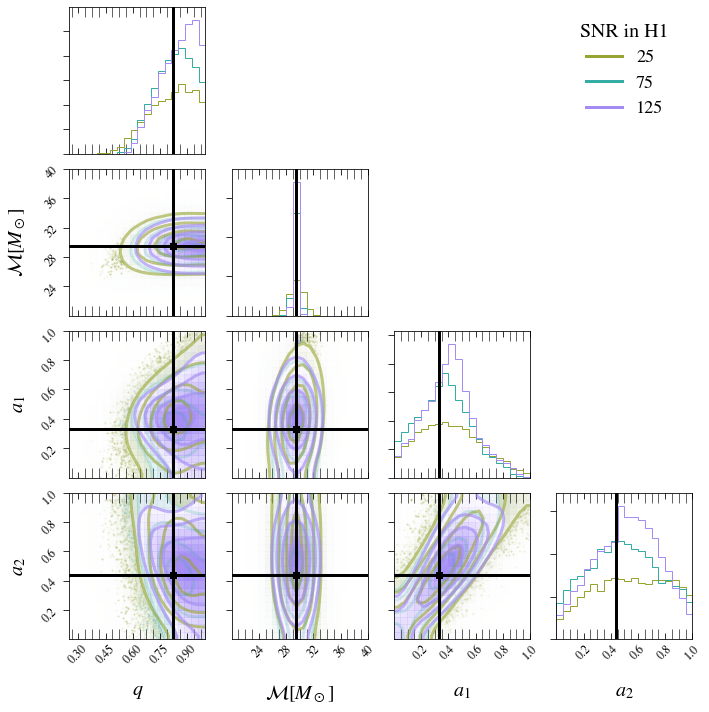

In [29]:
def SNRCornerPlot():
    """ Make a corner plot of Bilby runs on GR injections with various SNRs"""
    
    ## Quantities to plot, ranges, and labels
    quants = ['mass_ratio', 'chirp_mass', 'a_1', 'a_2']
    q_range = [(0.25, 1.0), (20, 40), (0.0, 1.0), (0.0, 1.0)]

    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    snr_values = ["25", "75", "125"]
    cs = sns.color_palette('husl', n_colors=len(snr_values) + 1)

    ## Get true injection values
    p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/dCS_0p0_25/'
    TruthDict = GetTruthDict(p)
    truths = [TruthDict[q] for q in quants]
    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]
    handles = []
    
    for SNR, color in zip(snr_values, cs[1:]):

        ## GR injections for Bilby with various SNRs
        p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/dCS_0p0_' + SNR + '/'
        vals = np.vstack([GetPosterior(p + 'outdir', q) for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, 
                      show_titles=False, smooth = 2.0, range = q_range, truths = truths, truth_color = 'black')

        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot(x, y, label=SNR, color = color)
        handles.append(l[0])


    legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'SNR in H1', loc = 'upper center')
    plt.setp(legend.get_title(),fontsize=20)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
        
    plt.tight_layout()
    plt.savefig('SNRCornerPlot.pdf')
    plt.show()
    
SNRCornerPlot()  

### Corner plot for injections with various search settings

In [5]:
def PriorsCornerPlot():
    """ Make a corner plot of Bilby runs on GR injections with 
        various settings for the priors and f_min """
    
    ## Quantities to plot
    quants = ['mass_ratio', 'chirp_mass', 'a_1', 'a_2']
    q_range = [(0.2, 1.0), (25, 40), (0.0, 1.0), (0.0, 1.0)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 
    
    ps = ["Test_FullSearchNoTilt_25_0p75", "Test_FullSearchNoTilt_35_0p99", "Test_FullSearch_35_0p99"]
    #ps = ["NoTilt_dCS_0p0_25", "NoTilt_dCS_0p0_75", "NoTilt_dCS_0p0_125"]
    #ps = ["NoTilt_dCS_0p35_25", "NoTilt_dCS_0p35_75", "NoTilt_dCS_0p35_125"]
    run_labels = [ps_dict[pp] for pp in ps]
    #cs = sns.color_palette('crest', n_colors=len(ps) + 1)
    cs = ['#07f5d9', '#95d1ed', '#e66157']
    
    ## Injected values -- the same for all of the runs
    p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + ps[0]
    TruthDict = GetTruthDict(p)
    truths = [TruthDict[q] for q in quants]
        
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]
    handles = []

    for p, color, rl in zip(ps, cs, run_labels):

        p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + p
        vals = np.vstack([GetPosterior(p + '/outdir', q) for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, smooth = 1.0, 
                      show_titles=False, truths = truths, truth_color = 'gray', range = q_range)

        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot(x, y, label=rl, color = color)
        handles.append(l[0])

    legend = ax_arr[0][2].legend(handles=handles, frameon=False, loc = 'upper center', fontsize=18)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.savefig('BilbyGRCheck.pdf')
    plt.show()
    
#PriorsCornerPlot()  

### Corner plots for dCS injections

In [67]:
SNR = '75'
base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
p_gr = base + 'AllSearch_dCS_0p0_' + SNR + '/'
PD_gr = PosteriorsDict(p_gr)
dcs_values = ["0p37"]
PDs = [PosteriorsDict(base + 'AllSearch_dCS_' + ell + '_' + SNR + '/') for ell in dcs_values]

{'chirp_mass': 29.422167356249002, 'mass_ratio': 0.8188310079446952, 'mass': 68.0, 'luminosity_distance': 500.6835541122321, 'a_1': 0.329892752405, 'a_2': 0.439940981499, 'dec': -1.26967171703, 'ra': 1.952318922, 'theta_jn': 3.141592653589793, 'tilt_1': 0.0, 'tilt_2': 3.141592653589793, 'phase': 0, 'psi': 0.824043851821, 'm_1': 37.38665093292035, 'm_2': 30.61334906707965, 'chi_eff': -8.157464352515946e-05}


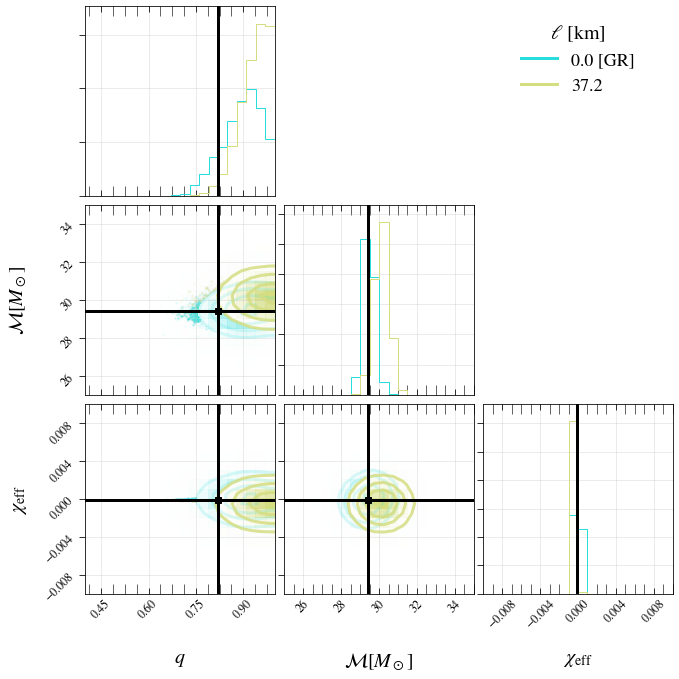

In [78]:
def dCSCornerPlot(SNR):
    """ Make a corner plot for Bilby runs on dCS injections with 
        various values of the coupling parameter.
        SNR refers to the signal to noise ratio of the run under consideration """
    
    ## Quantities to plot
    quants = ['mass_ratio', 'chirp_mass', 'chi_eff']
    q_range = [(0.4, 1.0), (25, 35), (-0.01, 0.01)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    ## dCS values to plot
    #dcs_values = [] #"0p25", "0p3", "0p35", "0p37"]
    cs = sns.color_palette('rainbow', n_colors=len(dcs_values) + 1)

     
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]

    smooth = 1.5
    
    ## Read in the GR values and plot GR results
    #p_gr = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/NoTilt_dCS_0p0_' + SNR + '/'
    #PD_gr = PosteriorsDict(p_gr)
    TruthDict = GetTruthDict(p_gr)
    print(TruthDict)
    truths = [TruthDict[q] for q in quants]
    mass = TruthDict['mass']
    vals_gr = np.vstack([PD_gr[q] for q in quants]).transpose()

    corner.corner(vals_gr, fig=fig, labels=labels,
                  title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0],
                  show_titles=False, truths = truths, truth_color = 'black', range = q_range, smooth = smooth)
    
    l_gr = ax_arr[0][dim-1].plot(x, y, label='%.1f [GR]' % EllinKm("0p0", mass), color = cs[0])
    handles = [l_gr[0]]

    ## Read in the dCS data and plot
    for ell, PD, color in zip(dcs_values, PDs, cs[1:]):

        #p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/NoTilt_dCS_' + ell + '_' + SNR + '/'
        #PD = PosteriorsDict(p)
        vals = np.vstack([PD[q] for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, 
                      show_titles=False, range = q_range, smooth = smooth)

        l = ax_arr[0][dim-1].plot(x, y, label='%.1f' % EllinKm(ell, mass), color = color)
        handles.append(l[0])


    legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'$\ell$ [km]', loc = 'upper center')
    plt.setp(legend.get_title(),fontsize=20)
    for ax in fig.get_axes():
        ax.grid(alpha = 0.3)
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.savefig('dCSCorner_' + SNR + '.pdf')
    plt.show()
    
#dCSCornerPlot('25')
dCSCornerPlot('75')
#dCSCornerPlot('125')

### Phase and polarization plot

In [7]:
def PhasePolarizationPlot():
    """ Plot phase and polarization reconstruction """
    
    ## Quantities to plot
    quants = ['phase', 'psi']
    q_range = [(-0.1, 2*pi), (0, 2*pi)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    ps = ["NoTilt_dCS_0p0_75"]
    
    run_labels = [ps_dict[pp] for pp in ps]
    cs = sns.color_palette('crest', n_colors=len(ps) + 1)

    ## Injected values -- the same for all of the runs
    p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + ps[0]
    TruthDict = GetTruthDict(p)
    truths = [TruthDict[q] for q in quants]
    truths[0] = pi - truths[0]
    print(truths)
        
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]
    handles = []

    for p, color, rl in zip(ps, cs, run_labels):

        p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + p
        vals = np.vstack([GetPosterior(p + '/outdir', q) for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, smooth = 1.0, 
                      show_titles=False, truths = truths, truth_color = 'gray', range = q_range)

        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot(x, y, label=rl, color = color)
        handles.append(l[0])

    legend = ax_arr[0][1].legend(handles=handles, frameon=False, loc = 'upper center', fontsize=18)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.savefig('PhasePolarization.pdf')
    plt.show()
    
#PhasePolarizationPlot()

### Plot Bayes factors as a function of SNR Bilby runs

In [8]:
def PlotBayesSNR():
    """ Plot Bayes factors for various dCS parameters as a function of SNR """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68
    
    ells = ["0p0","0p25", "0p3", "0p35", "0p37"]
    colors = ['black', 'violet', 'pink', 'lightblue', 'orange']
    snrs = [25, 75, 125]
    
    plt.figure(figsize=(10, 5))
    
    for ell, color in zip(ells, colors):

        bayes_arr = []

        for snr in snrs:

            p = base_dir + "NoTilt_dCS_" + ell + "_" + str(snr)
            bayes = BayesFactor(p)
            print(ell, snr, bayes)
            bayes_arr.append(bayes)

        plt.plot(snrs, bayes_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)
        
    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**2.0
    plt.plot(SNRS, snr_curve, color='gray', label = r'$\sim \mathrm{SNR}^{2}$', alpha = 0.1, lw = 15.0)

    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Log Bayes Factor')
    plt.xlabel('SNR')
    plt.tight_layout()
    plt.savefig('BayesSNR.pdf')
    plt.show()
    
#PlotBayesSNR()

### Plot Bayes factors as a function of $\ell$ for Bilby Runs

In [9]:
def PlotBayesEll():

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68

    ells = ["0p0", "0p2", "0p25", "0p28", "0p3", "0p33", "0p35", "0p36", "0p37"]
    ell_vals = [EllinKm(ell, mass) for ell in ells]
    snr = 75

    bayes_arr = []
    evidence_arr = []
    noise_evidence_arr = []

    for ell in ells:

        print(ell)
        p = base_dir + "NoTilt_dCS_" + ell + "_" + str(snr)
        bayes_arr.append(BayesFactor(p))
        evidence_arr.append(Evidence(p))
        noise_evidence_arr.append(NoiseEvidence(p))
        
    fig, axes = plt.subplots(3, figsize=(7.5,12), sharex = True)

    axes[0].plot(np.array(ell_vals)**4, evidence_arr, '--o', color = '#f72f64', label = 'Log Evidence', markersize = 10)
    axes[1].plot(np.array(ell_vals)**4, noise_evidence_arr, '--o', color = '#68e1e3', label = 'Log Noise Evidence', markersize = 10)
    axes[2].plot(np.array(ell_vals)**4, bayes_arr, '--o', color = 'orange', label = 'Log Bayes Factor', markersize = 10)

    for ax in axes:
        ax.legend(fontsize=17, loc = 'upper left', frameon=False)
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.grid()

    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.tight_layout()
    plt.savefig('BayesEll.pdf')
    plt.show()

### Understanding Bilby minimum frequency values

Bilby parameter estimation with the surrogate model requires specifying a minimum frequency f_sur_min, and this minuimum frequency must be greater than the minimum frequency of the waveform injection. If this criterion is not met (ie we ask for a lower f_sur_min than the injection f_injection_min), then Bilby throws an error saying that the requested minimum frequency, f_bilby_requested, is < f_injection_min. However, in practice, the f_bilby_requested reported by Bilby error messages is NOT equal to f_sur_min, which doesn't make sense. However, we can explore the relationship between these two quantities using the surrogate injection below:

for configuration:

mass_ratio = 1.0
chirp_mass = 20.0
a_1 = 0.99
a_2 = 0.99
tilt_1 = 0.0
tilt_2 = 3.14159265359
phi_12 = 0.0
phi_jl = 0.0


In [10]:
def BilbyMinimumFrequency():
    
    sur_fmin = [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]
    bil_fmin = [16.04293095, 16.69953829, 17.34314270, 17.97386363, 18.59182733, 19.19716692, 19.79002226, 20.37053975, \
              20.93887207, 21.49517785, 22.03962128, 22.57237175]
    ## Fit a relationship between the two
    fit = np.polyfit(sur_fmin, bil_fmin, 3)
    p = np.poly1d(fit)
    print(p)
    
    ## What the f_min should be for the run specified above
    fmin_should = 22.70617355 
    

    plt.figure(figsize=(8,8))

    plt.plot(sur_fmin, bil_fmin, '--o', color='red', label = 'values')
    plt.plot(sur_fmin, p(sur_fmin), label = 'quad fit', lw = 2.0, color = 'pink')

    plt.xlabel('Our requested minimum_frequency')
    plt.ylabel('Bilby reported requested fMin')

    plt.axhline(fmin_should, color='black', ls = '--', label = 'What Bilby says fMin should be')

    plt.legend()

    plt.show()

#BilbyMinimumFrequency()